# Equivalent Circuit Parameter Identification

This notebook provides example usage for identifying stationary parameters for a two RC branch Thevenin model. The Thevenin model represents an electrochemical battery through an empirical circuit model capable of capturing the electrical response of the battery. This model can be extended with a thermal submodel, as well as additional parallel resistor-capacitor branches.

### Setting up the Environment

Before we begin, we need to ensure that we have all the necessary tools. We will install PyBOP from its development branch and upgrade some dependencies:

In [20]:
%pip install --upgrade pip ipywidgets
%pip install pybop -q

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### Importing Libraries

With the environment set up, we can now import PyBOP alongside other libraries we will need:

In [21]:
import numpy as np

import pybop

### Importing Parameters

This can be completed by importing a JSON representation, such as the one in the PyBOP [examples](https://github.com/pybop-team/PyBOP/blob/develop/examples/scripts/parameters/initial_ecm_parameters.json). To import via JSON, either download the example file, or create your own and update the path below to reference the corresponding file.

In [22]:
# params = pybop.ParameterSet(
# json_path="examples/scripts/parameters/initial_ecm_parameters.json"
# )

Alternatively, define the initial parameter set with a dictionary. Ensure you have definitions for all R's, C's, and initial overpotentials for any additional RC elements.

In this example, we use the default parameter value for the "Open-circuit voltage [V] as provided by the original PyBaMM class. To update this, provide a function definition that matches this [function](https://github.com/pybamm-team/PyBaMM/blob/1943aa5ab2895b5378220595923dbae3d66b13c9/pybamm/input/parameters/ecm/example_set.py#L17).

In [23]:
params = pybop.ParameterSet(
    params_dict={
        "chemistry": "ecm",
        "Initial SoC": 0.5,
        "Initial temperature [K]": 25 + 273.15,
        "Cell capacity [A.h]": 5,
        "Nominal cell capacity [A.h]": 5,
        "Ambient temperature [K]": 25 + 273.15,
        "Current function [A]": 5,
        "Upper voltage cut-off [V]": 4.2,
        "Lower voltage cut-off [V]": 3.0,
        "Cell thermal mass [J/K]": 1000,
        "Cell-jig heat transfer coefficient [W/K]": 10,
        "Jig thermal mass [J/K]": 500,
        "Jig-air heat transfer coefficient [W/K]": 10,
        "Open-circuit voltage [V]": pybop.empirical.Thevenin().default_parameter_values[
            "Open-circuit voltage [V]"
        ],
        "R0 [Ohm]": 0.001,
        "Element-1 initial overpotential [V]": 0,
        "Element-2 initial overpotential [V]": 0,
        "R1 [Ohm]": 0.0002,
        "R2 [Ohm]": 0.0003,
        "C1 [F]": 13000,
        "C2 [F]": 36924,
        "Entropic change [V/K]": 0.0004,
    }
)

Now that the initial parameter set is constructed, we can start the PyBOP fitting process. First, we define the model class with two RC elements.

In [24]:
model = pybop.empirical.Thevenin(
    parameter_set=params.import_parameters(), options={"number of rc elements": 2}
)

In this example, we are going to try to fit all five parameters at once. This isn't recommend for real-life application as identifiablity is challenging to guarantee with this large a parameter space. To do this, we define the `pybop.parameters` as,

In [25]:
parameters = [
    pybop.Parameter(
        "R0 [Ohm]",
        prior=pybop.Gaussian(0.0002, 0.0001),
        bounds=[1e-4, 1e-2],
    ),
    pybop.Parameter(
        "R1 [Ohm]",
        prior=pybop.Gaussian(0.0001, 0.0001),
        bounds=[1e-5, 1e-2],
    ),
    pybop.Parameter(
        "R2 [Ohm]",
        prior=pybop.Gaussian(0.0001, 0.0001),
        bounds=[1e-5, 1e-2],
    ),
    pybop.Parameter(
        "C1 [F]",
        prior=pybop.Gaussian(10000, 2500),
        bounds=[2500, 5e4],
    ),
    pybop.Parameter(
        "C1 [F]",
        prior=pybop.Gaussian(10000, 2500),
        bounds=[2500, 5e4],
    ),
]

Let's create some synthetic data to identify the parameters. This data is then corrupted with a small amount of Gaussian noise to represent some additional uncertainty in the measured values. We can then form the `pybop.Dataset` from this data.

In [26]:
sigma = 0.001
t_eval = np.arange(0, 900, 2)
values = model.predict(t_eval=t_eval)
corrupt_values = values["Voltage [V]"].data + np.random.normal(0, sigma, len(t_eval))

# Form dataset
dataset = pybop.Dataset(
    {
        "Time [s]": t_eval,
        "Current function [A]": values["Current [A]"].data,
        "Voltage [V]": corrupt_values,
    }
)

The `FittingProblem` class provides us with a single class that holds all of the objects we need to evaluate our selected `SumSquaredError` cost function. 

In [27]:
problem = pybop.FittingProblem(model, parameters, dataset)
cost = pybop.SumSquaredError(problem)

The cost function can be interrogated manually via the `cost([params])` API. In this example, that would look like the following,

In [28]:
cost([0.001, 0.001, 0.001, 5000, 5000])

0.02481396482148223

Next, we construct the optimisation class with our algorithm of choice and run it. In this case, we select the CMA-ES method as it provides global optimisation capability. For the sake of reducing the runtime of this example, we limit the maximum iterations to 100; however, feel free to update this value.

In [33]:
optim = pybop.Optimisation(cost, optimiser=pybop.CMAES)
optim.set_max_iterations(300)
x, final_cost = optim.run()
print("Initial parameters:", cost.x0)
print("Estimated parameters:", x)

Initial parameters: [2.82225575e-04 1.72658962e-04 9.33921482e-05 1.06071260e+04
 4.57347160e+03]
Estimated parameters: [1.12930671e-03 6.47383206e-05 2.94920796e-04 1.06071280e+04
 4.57347320e+03]


## Plotting and Visualisation

PyBOP provides various plotting utilities to visualize the results of the optimisation.

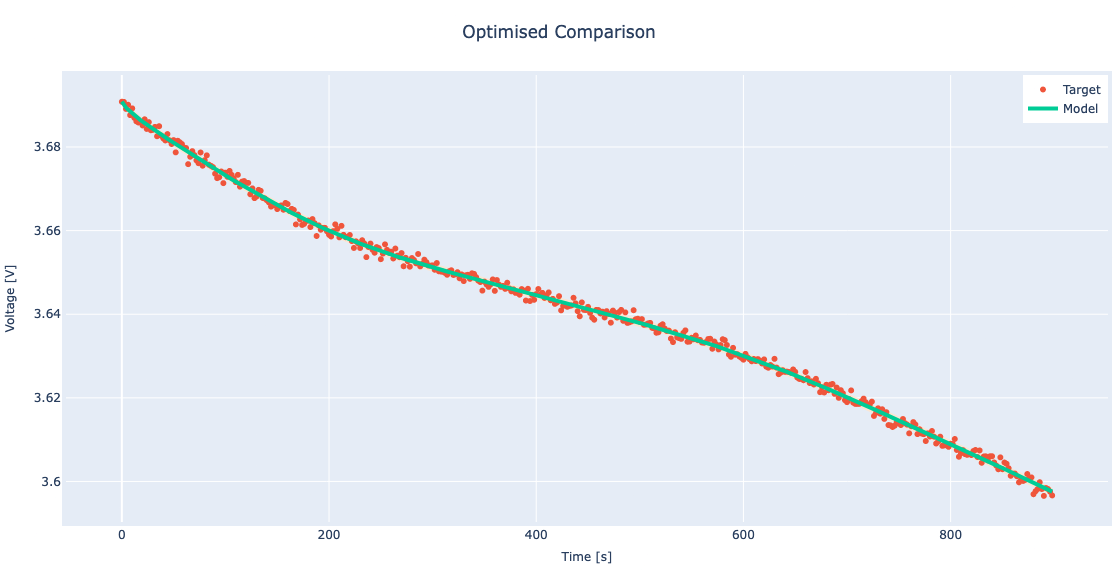

In [37]:
pybop.quick_plot(x, cost, title="Optimised Comparison");

### Convergence and Parameter Trajectories

To assess the optimisation process, we can plot the convergence of the cost function and the trajectories of the parameters:

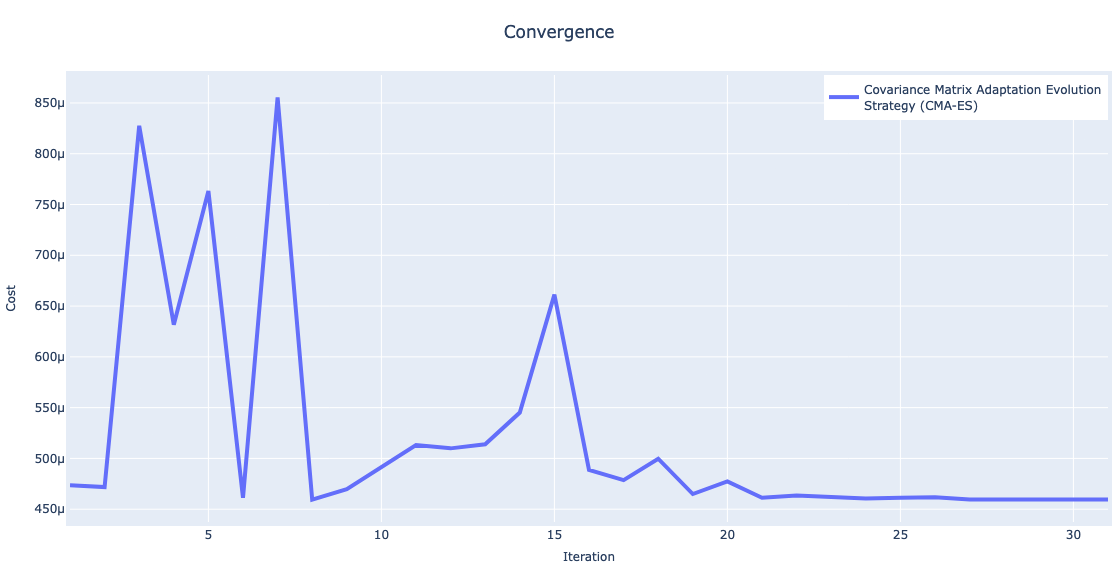

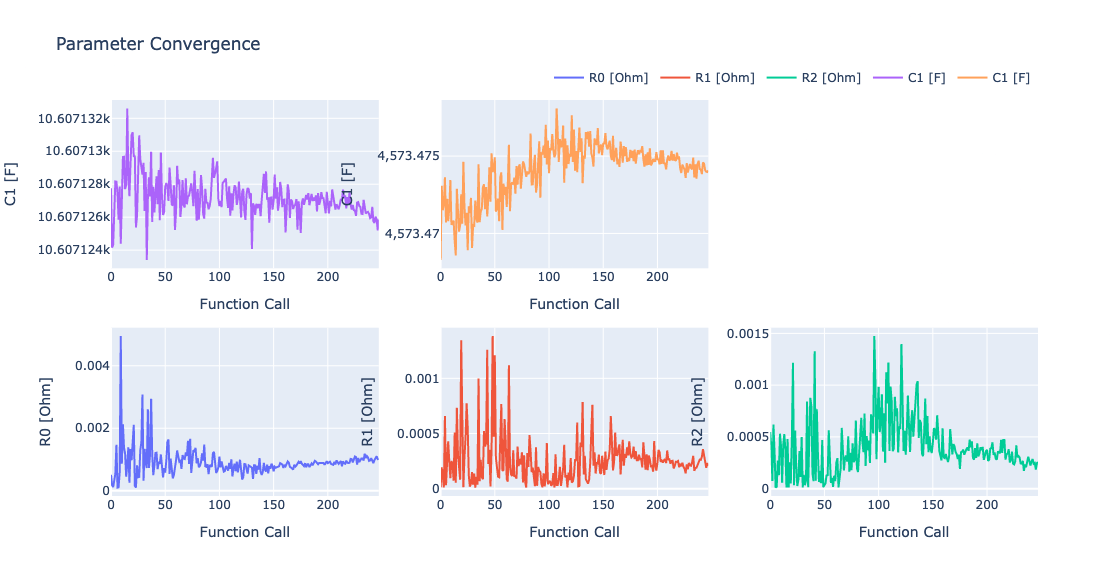

In [38]:
pybop.plot_convergence(optim)
pybop.plot_parameters(optim);

### Conclusion

This notebook illustrates how to perform parameter estimation using CMA-ES in PyBOP, providing insights into the optimisation process through various visualisations.